use VAE example to make code


Research VAEs to make VAE


###Imports

In [2]:
# Library imports
import numpy as np
import pandas as pd
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torchviz import make_dot
import matplotlib.pyplot as plt
from PIL import Image
import math
%matplotlib inline
from collections import OrderedDict

from skimage import io, transform
from sklearn.metrics import roc_auc_score
# import umap
from torch.utils.data import Dataset, DataLoader
from torchvision import utils

In [3]:
torch.__version__

'1.7.0'

### Directories

In [4]:
# Danny's Working Directory
data_dir = 'data/celeba'
save_dir = 'models'

# Danny's CelebA Paths
os.chdir('/home')
os.listdir()

['.git',
 'code',
 'docker',
 '.ipynb_checkpoints',
 'wandb',
 'vae.pt',
 '.gitignore',
 'data',
 'models',
 'README.md']

# The Data

### Load Data

### Transforms

In [5]:
img_channels_shape = (1, 64, 64)
img_shape = (64, 64)
scale_mu = 0.1307
scale_sd = 0.3081


# transforms
tfms_train = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(img_shape),
    transforms.ToTensor(),
    transforms.Normalize((scale_mu,), (scale_sd,))
])

tfms_val = tfms_test = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(img_shape),
    transforms.ToTensor(),
    transforms.Normalize((scale_mu,), (scale_sd,))
])

### CelebA Class

In [6]:
class CelebA(Dataset):
  def __init__(self, root_dir: str, partition: str, transform=None):
    # the image data
    self.img_dir = f"{root_dir}/img_align_celeba"

    # the partition data
    if partition=='train':
      self.partition_ix = 0
    elif partition=='val':
      self.partition_ix = 1
    elif partition=='test':
      self.partition_ix = 2
    else:
      raise ValueError("partition must be one of 'train', 'val', or 'test'")

    df_partitions = pd.read_csv(f"{root_dir}/list_eval_partition.csv")
    self.df_partitions = df_partitions[df_partitions['partition']==self.partition_ix]

    # the attribute data
    df_attributes = pd.read_csv(f"{root_dir}/list_attr_celeba.csv")

    # filter the attributes
    self.df_attributes = self.df_partitions.merge(df_attributes, how='left', on='image_id').drop(columns=['partition'])

    # transforms
    self.transform = transform

  def __len__(self):
    return self.df_attributes.shape[0]

  def __getitem__(self, ix):
    # image
    filepath = f"{self.img_dir}/{self.df_attributes.image_id[ix]}"
    image = Image.open(filepath)
    if self.transform:
      image = self.transform(image)

    # attributes
    attributes =self.df_attributes.iloc[ix, 1:].to_dict()

    return {'image': image, 'attributes': attributes}


In [25]:
# data settings:
batch_size=128 #input batch size for training (default: 64)
batch_size_test=1000 

# misc settings SET EACH TIME
device = torch.device(3)
kwargs = {'num_workers': 10, 'pin_memory': True}

# datasets
train_data = CelebA(data_dir, "train", transform = tfms_train)
test_data = CelebA(data_dir, "test", transform = tfms_test)

# Data Loaders
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size_test, shuffle=True)

# Define the VAE

### Helper Functions


In [12]:
class ResNetBlock(nn.Module):
    r"""Resnet style block for predicting color shift masks on input images. 
    
    Args:
        num_in (int) - number of input channels (and output channels)
        num_features (int) - number of intermediate channels in resnet block
    """

    def __init__(self, num_in, num_mid, kernel_size=5):

        super(ResNetBlock, self).__init__()
        
        self.res = nn.Sequential(OrderedDict([
            # conv block 1
            ('conv0', nn.Conv2d(num_in, num_mid, kernel_size, stride=1,
                                padding=(kernel_size-1)//2, bias=False)),
            ('norm0', nn.BatchNorm2d(num_mid)),
            ('relu0', nn.ReLU(inplace=True)),
            # conv block 2
            ('conv1', nn.Conv2d(num_mid, num_in, kernel_size, stride=1,
                                padding=(kernel_size-1)//2, bias=False)),
            ('norm1', nn.BatchNorm2d(num_in)),

        ]))
        
        self.relu1 = nn.ReLU(inplace=True)

    def forward(self, x):
        # resnet style output: add input to features at relu
        return self.relu1(x + self.res(x))
    
class EncoderBlock(nn.Module):
    def __init__(self, n_in, n_mid, n_out, kernel_size=5):
        super(EncoderBlock, self).__init__()
        
        self.block = nn.Sequential(
            ResNetBlock(n_in, n_mid, kernel_size),
            nn.Conv2d(n_in, n_out, kernel_size=kernel_size, padding=(kernel_size-1)//2, stride=2),
            nn.BatchNorm2d(n_out),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.block(x)
        
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
# ------------------------------------------------------------------------------------------    

class DecoderBlock(nn.Module):
    def __init__(self, n_in, n_mid, n_out, kernel_size=6):
        super(DecoderBlock, self).__init__()
        
        self.block = nn.Sequential(
            ResNetBlock(n_in, n_mid, kernel_size),
            nn.Conv2d(n_in, n_out, kernel_size=kernel_size, padding=(kernel_size-1)//2),
            nn.BatchNorm2d(n_out),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode="bilinear") #changed from nearest to bilinear 
        )
        
    def forward(self, x):
            return self.block(x)
        
class UnFlatten(nn.Module):
    def __init__(self, shape):
        super(UnFlatten, self).__init__()
        self.shape = shape
        
    def forward(self, input):
        return input.view(input.size(0), self.shape[0], self.shape[1], self.shape[2])

### Encoder

In [43]:
class Encoder(nn.Module):
    def __init__(self, input_shape, n_mid=(64,32,16,16), n_res=32, kernel_size=5):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            # start
            nn.Conv2d(input_shape[0], n_mid[0], kernel_size=7, padding=3, stride=2),
            #nn.MaxPool2d(kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(n_mid[0]),
            nn.ReLU(),
            # encoding blocks
            EncoderBlock(n_mid[0], n_res, n_mid[1], kernel_size),
            EncoderBlock(n_mid[1], n_res, n_mid[2], kernel_size),
            EncoderBlock(n_mid[2], n_res, n_mid[3], kernel_size),
            Flatten()
        )
        
    def forward(self, x):
        return self.encoder(x)

In [44]:
encoder = Encoder(img_channels_shape).to(device)
batch_ix = 7
for i, batch in enumerate(train_loader):
  if i==batch_ix:
    images = batch['image']

    z = encoder(images.to(device))
    print(images.shape, z.shape)
    break

torch.Size([128, 1, 64, 64]) torch.Size([128, 256])


### Decoder

In [45]:
class Decoder(nn.Module):
    def __init__(self, output_shape=(1,64,64), n_mid=(64,32,16,16), n_res=32, kernel_size=7):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(
            UnFlatten((n_mid[-1], output_shape[1]//2**4, output_shape[2]//2**4)),
            nn.Upsample(scale_factor=2, mode="bilinear"), #changed from nearest to bilinear 
            DecoderBlock(n_mid[-1], n_res, n_mid[-2], kernel_size),
            DecoderBlock(n_mid[-2], n_res, n_mid[-3], kernel_size),
            DecoderBlock(n_mid[-3], n_res, n_mid[-4], kernel_size),
            nn.Conv2d(n_mid[-4], output_shape[0], kernel_size, padding=(kernel_size-1)//2),
            nn.BatchNorm2d(output_shape[0]),
            nn.Sigmoid()
        )  
        
    def forward(self, x):
        x = self.decoder(x)
        
        return x


In [46]:
decoder = Decoder().to(device)
batch_ix = 5
for i, batch in enumerate(train_loader):
  if i==batch_ix:
    images = batch['image']

    z = encoder(images.to(device))
    xp = decoder(z)
    print(images.shape, z.shape, xp.shape)
    break

torch.Size([128, 1, 64, 64]) torch.Size([128, 256]) torch.Size([128, 1, 64, 64])


### VAE

In [47]:
class VAE(nn.Module):
    def __init__(self, image_shape, n_mid, n_res, z_dim):
        super(VAE, self).__init__()
        
        #self.hparams=hparams        
        #following are assingment of the constructor arguments to the class object
        self.image_shape = image_shape
        self.n_mid = n_mid
        self.n_res = n_res
        self.z_dim = z_dim
        
        # encoder and decoder
        self.encoder = Encoder(input_shape = self.image_shape, 
                               n_mid = self.n_mid, 
                               n_res = self.n_res, 
                               kernel_size=5)
        self.decoder = Decoder(output_shape=self.image_shape, 
                               n_mid = self.n_mid, 
                               n_res = self.n_res, 
                               kernel_size=5)
        
        shape = self.image_shape
        self.h_dim = (shape[0]*shape[1]*shape[2]) // (4**4) * self.n_mid[-1]
        self.lin_mu = nn.Linear(self.h_dim, self.z_dim)
        self.lin_logvar = nn.Linear(self.h_dim, self.z_dim)
        self.lin_decode = nn.Linear(self.z_dim, self.h_dim)
        
    def bottleneck(self, h):
        mu, logvar = self.lin_mu(h), self.lin_logvar(h)

        if self.training:
            z = self.reparameterize(mu, logvar)
        else:
            z = mu
        return z, mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn_like(std)
        z = mu + std * esp
        return z
    
    def forward(self, x):
        h = self.encoder(x)
        
        z, mu, logvar = self.bottleneck(h)
        z = self.lin_decode(z)
        
        return self.decoder(z), mu, logvar 

In [48]:
vae = VAE(img_channels_shape, n_mid=(64,32,16,16), n_res=32, z_dim=32).to(device)
print("Number of free parameters: ", sum(p.numel() for p in vae.parameters() if p.requires_grad))
batch_ix = 5
for i, batch in enumerate(train_loader):
  if i==batch_ix:
    images = batch['image']

    xp, mu, logvar = vae(images.to(device))
    print(images.shape, xp.shape, mu.shape, logvar.shape)
    break

Number of free parameters:  453491
torch.Size([128, 1, 64, 64]) torch.Size([128, 1, 64, 64]) torch.Size([128, 32]) torch.Size([128, 32])


# Train

In [49]:
beta=0.025
optimizer = optim.Adam(vae.parameters(), lr=0.01)
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var, beta=1):
    BCE = F.binary_cross_entropy(recon_x.view(-1, np.prod(img_shape)), x.view(-1, np.prod(img_shape)), reduction='mean')
    KLD = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE+beta*KLD, BCE, KLD

def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, batch in enumerate(train_loader):
        images = batch['image']
        images = images.to(device)
        optimizer.zero_grad()
        
        recon, mu, log_var = vae(images)
        images = images*scale_sd+scale_mu
        loss, _, _ = loss_function(recon, images, mu, log_var, beta=beta)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % batch_size == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(images), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(images)))
            
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for batch in test_loader:
            images = batch['image']
            images = images.to(device)
            recon, mu, log_var = vae(images)
            
            # sum up batch loss
            images = images*scale_sd+scale_mu
            loss, bce, kld = loss_function(recon, images, mu, log_var, beta=beta)
            test_loss += loss.item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

    return test_loss

In [ ]:
best_test = 10**10
for epoch in range(1):
    train(epoch)
    test_loss = test()

    if test_loss < best_test:
      best_test = test_loss
      torch.save(vae.state_dict(), 'vae.pt')

vae.load_state_dict(torch.load('vae.pt'))

Train Epoch: 0 [0/162770 (0%)]	Loss: 0.006137
Train Epoch: 0 [16384/162770 (10%)]	Loss: 0.004534
Train Epoch: 0 [32768/162770 (20%)]	Loss: 0.004563
Train Epoch: 0 [49152/162770 (30%)]	Loss: 0.004412
Train Epoch: 0 [65536/162770 (40%)]	Loss: 0.004454
Train Epoch: 0 [81920/162770 (50%)]	Loss: 0.004423
Train Epoch: 0 [98304/162770 (60%)]	Loss: 0.004400
Train Epoch: 0 [114688/162770 (70%)]	Loss: 0.004339
Train Epoch: 0 [131072/162770 (81%)]	Loss: 0.004348


# Save the encoder to drive

In [ ]:
vae.encoder

In [ ]:
torch.save(vae.encoder.state_dict(), save_dir + '/celeba_encoder_256.pt')

# Visualize

In [37]:
batch_ix = 5
vae.eval()
for i, batch in enumerate(train_loader):
  if i==batch_ix:
    images = batch['image']
    with torch.no_grad():
      xp, mu, logvar = vae(images.to(device))
    print(images.shape, xp.shape, mu.shape, logvar.shape)
    break

torch.Size([128, 1, 64, 64]) torch.Size([128, 1, 64, 64]) torch.Size([128, 64]) torch.Size([128, 64])


In [38]:
# Helper function to show batch of images
def show_images(images, nrow=8):
    plt.figure(figsize=(20,20))
    """Show image with landmarks for a batch of samples."""
    num_images = images.shape[0]
    grid_border_size = 1

    grid = utils.make_grid(images, nrow=nrow, padding = grid_border_size, scale_each=True, normalize=True)[0]
    plt.imshow(grid.numpy().transpose((0, 1)))

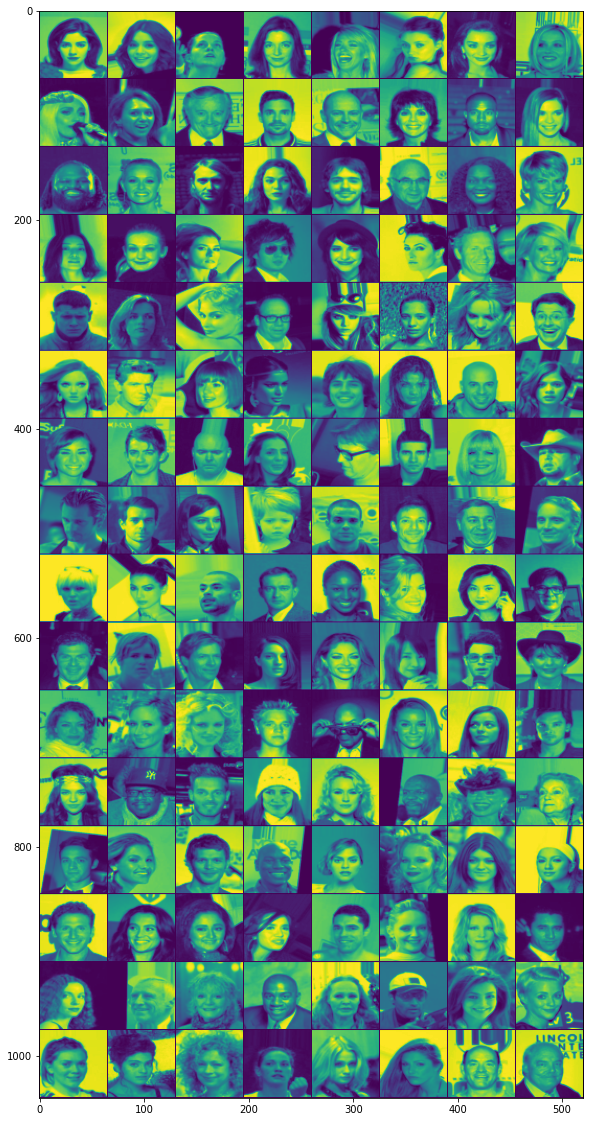

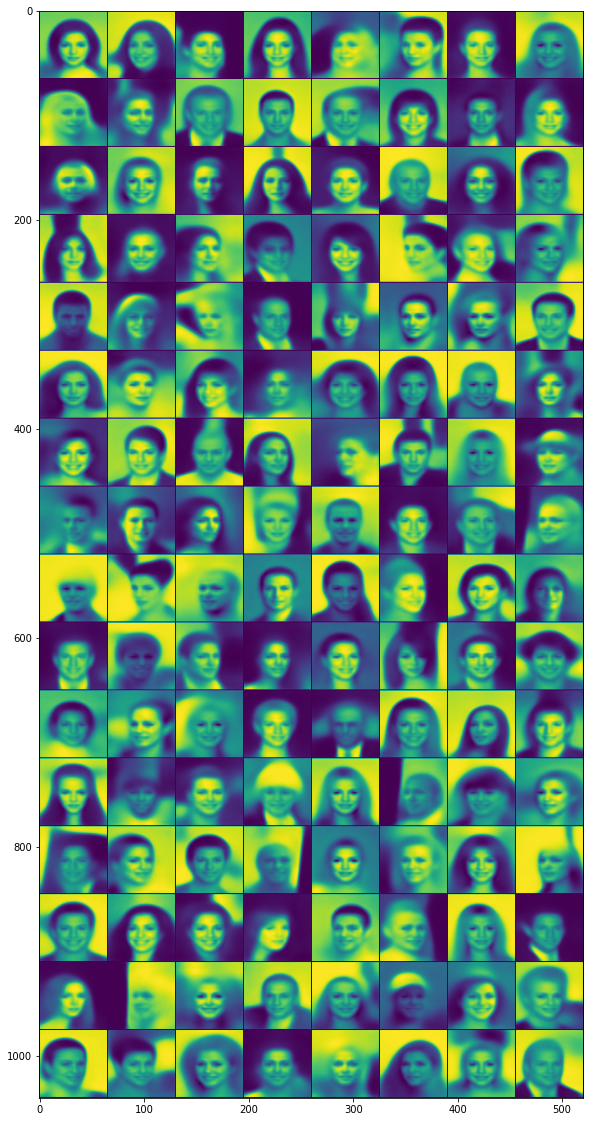

In [39]:
show_images(images.cpu())
show_images(xp.detach().cpu())